## Регуляризации

### Давайте теперь рассмотрим различные методы прунинга и регуляризации моделей

##### Подключим библиотеки

In [45]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

###### Прочтем данные

In [5]:
# Read data
data = pd.read_csv("sonar.csv", header=None)
X = data.iloc[:, 0:60]
y = data.iloc[:, 60]

display(data.head())

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [6]:
# Label encode the target from string to integer
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

Базовая модель, без регуляризаций

In [7]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

In [8]:
def model_train(model, X_train, y_train, X_val, y_val,
                n_epochs=300, batch_size=16):
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    for epoch in range(n_epochs):
        for start in batch_start:
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # evaluation
    model.eval()
    y_pred = model(X_val)
    acc = (y_pred.round() == y_val).float().mean()
    acc = float(acc)
    return acc

In [9]:
# run 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True)
accuracies = []
for train, test in kfold.split(X, y):
    # create model, train, and get accuracy
    model = BaseModel()
    acc = model_train(model, X[train], y[train], X[test], y[test])
    print("Accuracy: %.2f" % acc)
    accuracies.append(acc)

# evaluate the model
mean = np.mean(accuracies)
std = np.std(accuracies)
print("Overal for baseline model: %.2f%% (+/- %.2f%%)" % (mean*100, std*100))

Accuracy: 0.86
Accuracy: 0.71
Accuracy: 0.90
Accuracy: 0.90
Accuracy: 0.81
Accuracy: 0.90
Accuracy: 0.71
Accuracy: 0.86
Accuracy: 0.80
Accuracy: 0.80
Overal for baseline model: 82.67% (+/- 6.87%)


### Dropout
А теперь добавим дропаут в начале

In [10]:
class SonarModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2) ## Adding a dropout layer
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.dropout(x)
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

In [11]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
accuracies = []
for train, test in kfold.split(X, y):
    # create model, train, and get accuracy
    model = SonarModel()
    acc = model_train(model, X[train], y[train], X[test], y[test])
    print("Accuracy: %.2f" % acc)
    accuracies.append(acc)
    
# evaluate the model
mean = np.mean(accuracies)
std = np.std(accuracies)
print("Overall for input-dropout: %.2f%% (+/- %.2f%%)" % (mean*100, std*100))

Accuracy: 0.86
Accuracy: 0.86
Accuracy: 0.71
Accuracy: 0.71
Accuracy: 0.67
Accuracy: 0.90
Accuracy: 0.86
Accuracy: 0.76
Accuracy: 0.85
Accuracy: 0.80
Overall for input-dropout: 79.83% (+/- 7.56%)


А теперь применим дропаут к внутреннему слою

In [12]:
class SonarModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

In [13]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
accuracies = []
for train, test in kfold.split(X, y):
    # create model, train, and get accuracy
    model = SonarModel()
    acc = model_train(model, X[train], y[train], X[test], y[test])
    print("Accuracy: %.2f" % acc)
    accuracies.append(acc)

# evaluate the model
mean = np.mean(accuracies)
std = np.std(accuracies)
print("OVeral for hidden-dropout: %.2f%% (+/- %.2f%%)" % (mean*100, std*100))

Accuracy: 0.81
Accuracy: 0.71
Accuracy: 0.86
Accuracy: 0.90
Accuracy: 0.86
Accuracy: 0.71
Accuracy: 0.90
Accuracy: 0.81
Accuracy: 0.85
Accuracy: 0.85
OVeral for hidden-dropout: 82.71% (+/- 6.40%)


### L1, L2 and elastic

##### L1 model

In [16]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28 * 1, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 10)
        )


    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)
  
    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

In [47]:
torch.manual_seed(42)
  
# Prepare CIFAR-10 dataset
dataset = MNIST(os.getcwd(), download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
losses_l1 = []

In [49]:
# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum
    train_loss = 0.0
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get inputs
        inputs, targets = data

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Compute L1 loss component
        l1_weight = 1.0
        l1_parameters = []
        for parameter in mlp.parameters():
            l1_parameters.append(parameter.view(-1))
        l1 = l1_weight * mlp.compute_l1_loss(torch.cat(l1_parameters))

        # Add L1 loss component
        loss += l1

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        minibatch_loss = loss.item()
        train_loss += minibatch_loss
        losses_l1.append(train_loss/(i+1))
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.5f (of which %.5f L1 loss)' %
                (i + 1, minibatch_loss, l1))
            current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 65.37165 (of which 63.03826 L1 loss)
Loss after mini-batch  1000: 13.89388 (of which 11.59544 L1 loss)
Loss after mini-batch  1500: 3.68279 (of which 1.37783 L1 loss)
Loss after mini-batch  2000: 2.93884 (of which 0.63626 L1 loss)
Loss after mini-batch  2500: 2.93945 (of which 0.63686 L1 loss)
Loss after mini-batch  3000: 2.93972 (of which 0.63713 L1 loss)
Loss after mini-batch  3500: 2.93790 (of which 0.63531 L1 loss)
Loss after mini-batch  4000: 2.94024 (of which 0.63766 L1 loss)
Loss after mini-batch  4500: 2.94047 (of which 0.63787 L1 loss)
Loss after mini-batch  5000: 2.93992 (of which 0.63733 L1 loss)
Loss after mini-batch  5500: 2.94008 (of which 0.63750 L1 loss)
Loss after mini-batch  6000: 2.93733 (of which 0.63473 L1 loss)
Starting epoch 2
Loss after mini-batch   500: 2.93971 (of which 0.63712 L1 loss)
Loss after mini-batch  1000: 2.93886 (of which 0.63628 L1 loss)
Loss after mini-batch  1500: 2.94044 (of which 0.63786 L1 loss)
Lo

### L2 regularization

In [52]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28 * 1, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 10)
        )


    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [53]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
  
mlp = MLP()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
losses_l2 = []

In [55]:
for epoch in range(0, 5): # 5 epochs at maximum
    train_loss = 0.0
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
        inputs, targets = data

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Compute l2 loss component
        l2_weight = 1.0
        l2_parameters = []
        for parameter in mlp.parameters():
            l2_parameters.append(parameter.view(-1))
        l2 = l2_weight * mlp.compute_l2_loss(torch.cat(l2_parameters))

        # Add l2 loss component
        loss += l2

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        minibatch_loss = loss.item()
        train_loss += minibatch_loss
        losses_l2.append(train_loss/(i+1))
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.5f (of which %.5f l2 loss)' %
                (i + 1, minibatch_loss, l2))
            current_loss = 0.0

  # Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 6.71983 (of which 4.38983 l2 loss)
Loss after mini-batch  1000: 3.45458 (of which 1.15703 l2 loss)
Loss after mini-batch  1500: 2.55949 (of which 0.26261 l2 loss)
Loss after mini-batch  2000: 2.34712 (of which 0.05075 l2 loss)
Loss after mini-batch  2500: 2.31443 (of which 0.00849 l2 loss)
Loss after mini-batch  3000: 2.30505 (of which 0.00117 l2 loss)
Loss after mini-batch  3500: 2.30058 (of which 0.00021 l2 loss)
Loss after mini-batch  4000: 2.30278 (of which 0.00009 l2 loss)
Loss after mini-batch  4500: 2.30409 (of which 0.00009 l2 loss)
Loss after mini-batch  5000: 2.30292 (of which 0.00009 l2 loss)
Loss after mini-batch  5500: 2.30126 (of which 0.00007 l2 loss)
Loss after mini-batch  6000: 2.30254 (of which 0.00005 l2 loss)
Starting epoch 2
Loss after mini-batch   500: 2.30206 (of which 0.00007 l2 loss)
Loss after mini-batch  1000: 2.30201 (of which 0.00007 l2 loss)
Loss after mini-batch  1500: 2.30175 (of which 0.00010 l2 loss)
Loss a

#### Простой путь

В торче есть и более простой способ добавить L2-регуляризацию. <br>
```optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=1.0)```

##### Реализуйте тренеровку, используя weight_decay

In [ ]:
optimizer = torch.optim.Adam(???)
losses_l2_wd = []

In [ ]:
for epoch in range(0, 5): # 5 epochs at maximum
    train_loss = 0.0
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        ### YOUR CODE HERE
        
        
        
        ### END CODE

        # Print statistics
        minibatch_loss = loss.item()
        train_loss += minibatch_loss
        losses_l2_wd.append(train_loss/(i+1))
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.5f (of which %.5f l2 loss)' %
                (i + 1, minibatch_loss, l2))
            current_loss = 0.0

  # Process is complete.
print('Training process has finished.')

### Elastic Net

Elastic Net - взвешшеная сумма  L1 и L2 регуляризаций:

$$\lambda_{L1} \times \sum_f{ _{i=1}^{n}} | w_i | + \lambda_{L2} \times \sum_f{ _{i=1}^{n}} w_i^2$$

И она потом добавляется к обычному лоссу:

$$\text{full_loss = original_loss + } \lambda_{L1} \times \sum_f{ _{i=1}^{n}} | w_i | + \lambda_{L2} \times \sum_f{ _{i=1}^{n}} w_i^2 $$

In [56]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28 * 1, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 10)
        )


    def forward(self, x):
        return self.layers(x)

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [57]:
torch.manual_seed(42)
  
# Prepare CIFAR-10 dataset
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
losses_elastic = []

In [58]:
for epoch in range(0, 5): # 5 epochs at maximum
    train_loss = 0.00
# Print epoch
    print(f'Starting epoch {epoch+1}')

# Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get inputs
        inputs, targets = data

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Specify L1 and L2 weights
        l1_weight = 0.3
        l2_weight = 0.7

        # Compute L1 and L2 loss component
        parameters = []
        for parameter in mlp.parameters():
            parameters.append(parameter.view(-1))
        l1 = l1_weight * mlp.compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * mlp.compute_l2_loss(torch.cat(parameters))

        # Add L1 and L2 loss components
        loss += l1
        loss += l2

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        minibatch_loss = loss.item()
        train_loss += minibatch_loss
        losses_elastic.append(train_loss/(i+1))
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.5f (of which %.5f L1 loss; %0.5f L2 loss)' %
                (i + 1, minibatch_loss, l1, l2))
            current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 24.79362 (of which 19.77028 L1 loss; 2.74106 L2 loss)
Loss after mini-batch  1000: 7.52453 (of which 4.81060 L1 loss; 0.39591 L2 loss)
Loss after mini-batch  1500: 3.03675 (of which 0.69903 L1 loss; 0.03131 L2 loss)
Loss after mini-batch  2000: 2.48315 (of which 0.18056 L1 loss; 0.00001 L2 loss)
Loss after mini-batch  2500: 2.48123 (of which 0.17864 L1 loss; 0.00001 L2 loss)
Loss after mini-batch  3000: 2.48011 (of which 0.17751 L1 loss; 0.00001 L2 loss)
Loss after mini-batch  3500: 2.48004 (of which 0.17745 L1 loss; 0.00001 L2 loss)
Loss after mini-batch  4000: 2.47988 (of which 0.17730 L1 loss; 0.00001 L2 loss)
Loss after mini-batch  4500: 2.47929 (of which 0.17670 L1 loss; 0.00001 L2 loss)
Loss after mini-batch  5000: 2.47955 (of which 0.17696 L1 loss; 0.00001 L2 loss)
Loss after mini-batch  5500: 2.48013 (of which 0.17754 L1 loss; 0.00001 L2 loss)
Loss after mini-batch  6000: 2.48089 (of which 0.17830 L1 loss; 0.00001 L2 loss)
Starting 

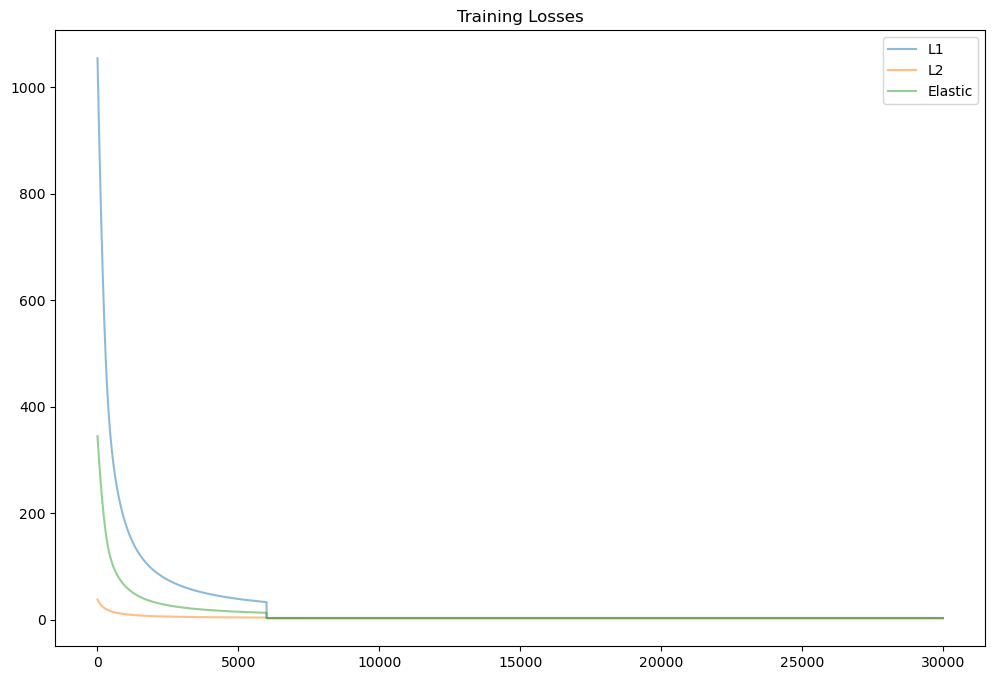

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
#losses_batchnorm = np.array(losses_batchnorm)
#losses_no_norm = np.array(losses_no_norm)
plt.plot(losses_l1, label='L1', alpha=0.5)
plt.plot(losses_l2, label='L2', alpha=0.5)
plt.plot(losses_elastic, label='Elastic', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Batch-Norm

In [32]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training and test datasets
train_data = MNIST(root='data', train=True,
                            download=True, transform=transform)

test_data = MNIST(root='data', train=False,
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

16.5%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100.0%
100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Теперь в похожую полносвязную сетку добавим дропаут

In [33]:
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, use_batch_norm, input_size=784, hidden_dim=256, output_size=10):
        """
        Creates a PyTorch net using the given parameters.
        
        :param use_batch_norm: bool
            Pass True to create a network that uses batch normalization; False otherwise
            Note: this network will not use batch normalization on layers that do not have an
            activation function.
        """
        super(NeuralNet, self).__init__() # init super
        
        # Default layer sizes
        self.input_size = input_size # (28*28 images)
        self.hidden_dim = hidden_dim
        self.output_size = output_size # (number of classes)
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        # define hidden linear layers, with optional batch norm on their outputs
        # layers with batch_norm applied have no bias term
        if use_batch_norm:
            self.fc1 = nn.Linear(input_size, hidden_dim*2, bias=False)
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2)
        else:
            self.fc1 = nn.Linear(input_size, hidden_dim*2)
            
        # define *second* hidden linear layers, with optional batch norm on their outputs
        if use_batch_norm:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
            self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        else:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # third and final, fully-connected layer
        self.fc3 = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers + optional batch norm + relu activation
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = F.relu(x)
        # second layer
        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)
        # third layer, no batch norm or activation
        x = self.fc3(x)
        return x


In [34]:
net_batchnorm = NeuralNet(use_batch_norm=True)
net_no_norm = NeuralNet(use_batch_norm=False)

print(net_batchnorm)
print()
print(net_no_norm)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [35]:
def train(model, n_epochs=10):
    # number of epochs to train the model
    n_epochs = n_epochs
    # track losses
    losses = []
        
    # optimization strategy 
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # set the model to training mode
    model.train()
    
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        batch_count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss += loss.item() # add up avg batch loss
            batch_count +=1                

        # print training statistics 
        losses.append(train_loss/batch_count)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss/batch_count))
    
    # return all recorded batch losses
    return losses      

In [37]:
losses_batchnorm = train(net_batchnorm)

Epoch: 1 	Training Loss: 0.391168
Epoch: 2 	Training Loss: 0.165785
Epoch: 3 	Training Loss: 0.115549
Epoch: 4 	Training Loss: 0.086180
Epoch: 5 	Training Loss: 0.066142
Epoch: 6 	Training Loss: 0.051552
Epoch: 7 	Training Loss: 0.040513
Epoch: 8 	Training Loss: 0.032000
Epoch: 9 	Training Loss: 0.025399
Epoch: 10 	Training Loss: 0.020293


In [38]:
losses_no_norm = train(net_no_norm)

Epoch: 1 	Training Loss: 1.627025
Epoch: 2 	Training Loss: 0.526522
Epoch: 3 	Training Loss: 0.387258
Epoch: 4 	Training Loss: 0.338334
Epoch: 5 	Training Loss: 0.308756
Epoch: 6 	Training Loss: 0.286501
Epoch: 7 	Training Loss: 0.267729
Epoch: 8 	Training Loss: 0.250841
Epoch: 9 	Training Loss: 0.235325
Epoch: 10 	Training Loss: 0.221022


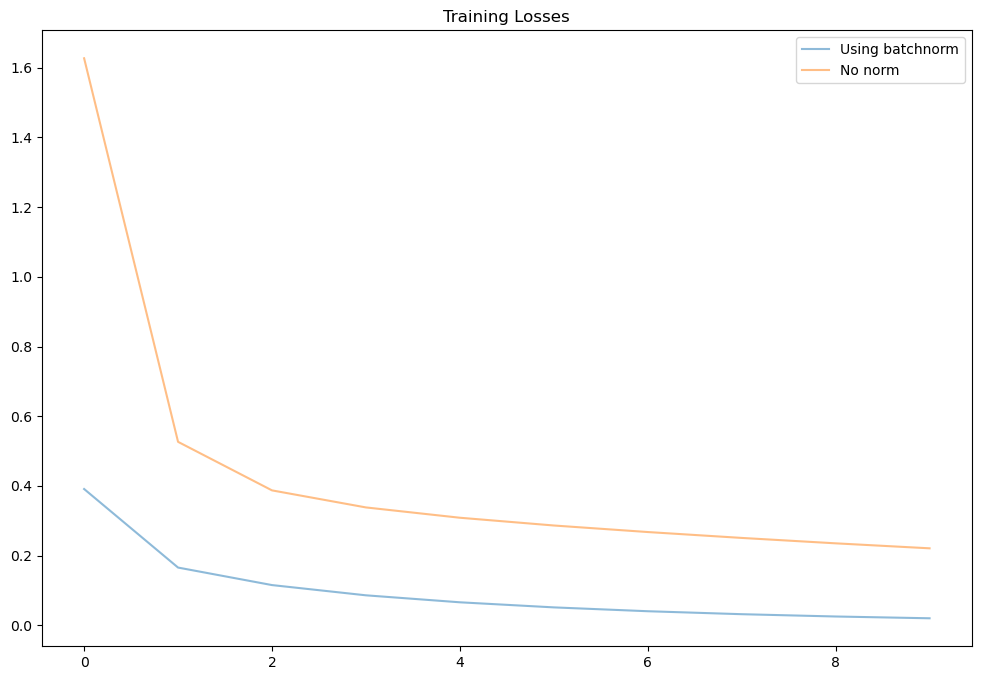

In [40]:
# compare
fig, ax = plt.subplots(figsize=(12,8))
#losses_batchnorm = np.array(losses_batchnorm)
#losses_no_norm = np.array(losses_no_norm)
plt.plot(losses_batchnorm, label='Using batchnorm', alpha=0.5)
plt.plot(losses_no_norm, label='No norm', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [41]:
def test(model, train):
    # initialize vars to monitor test loss and accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0

    # set model to train or evaluation mode
    # just to see the difference in behavior
    if(train==True):
        model.train()
    if(train==False):
        model.eval()
    
    # loss criterion
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += loss.item()*batch_size
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [42]:
test(net_batchnorm, train=True)

Test Loss: 0.083724

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 96% (1000/1032)
Test Accuracy of     3: 97% (982/1010)
Test Accuracy of     4: 97% (957/982)
Test Accuracy of     5: 97% (871/892)
Test Accuracy of     6: 97% (934/958)
Test Accuracy of     7: 97% (1000/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 96% (972/1009)

Test Accuracy (Overall): 97% (9757/10000)


In [43]:
test(net_batchnorm, train=False)

Test Loss: 0.072316

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 98% (1123/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 97% (989/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 97% (937/958)
Test Accuracy of     7: 96% (993/1028)
Test Accuracy of     8: 96% (939/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 97% (9773/10000)


In [44]:
test(net_no_norm, train=False)

Test Loss: 0.212562

Test Accuracy of     0: 98% (965/980)
Test Accuracy of     1: 98% (1114/1135)
Test Accuracy of     2: 90% (937/1032)
Test Accuracy of     3: 93% (942/1010)
Test Accuracy of     4: 93% (916/982)
Test Accuracy of     5: 91% (816/892)
Test Accuracy of     6: 95% (911/958)
Test Accuracy of     7: 92% (955/1028)
Test Accuracy of     8: 90% (885/974)
Test Accuracy of     9: 93% (941/1009)

Test Accuracy (Overall): 93% (9382/10000)
